In [2]:
#CONNEXION à google drive
import pandas as pd
from google.colab import drive

drive.mount('/Drive')

Mounted at /Drive


In [3]:
#PARAMETRES!!!
isSaveData = False
pathSaveCsv = '/Drive/My Drive'
isRegenerateKeywords = False
isManualDataFrame=False
import re  
import requests
import io
import pandas as pd
from nltk.tokenize import PunktSentenceTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk as nltk

In [4]:
def creerDataframePourArticleManuel(madescription, madesignation):
  dic={"designation":[madesignation],"description":[madescription],"productid":0,"imageid":None,"prdtypecode":None}
  X=pd.DataFrame(dic)
  return X

In [5]:
#CHARGEMENT des fichiers
def load_X(isManualDataFrame,madescription, madesignation):
  if (not isManualDataFrame):
    url = "https://raw.githubusercontent.com/JulienJ-44/rakuteam/main/Datasets/Dataset_challenge.csv"
    download = requests.get(url).content
    X=pd.read_csv(io.StringIO(download.decode('utf-8')), index_col=0)
  else:
    #OU création d'un dataframe
    X=creerDataframePourArticleManuel(madescription, madesignation)
  return X

In [6]:
def cleaningX_to_df(X):
  #PREPARATION: FUSION de X et y et remplacement des VALEURS MANQUANTES par ""
  df = X.drop(['imageid'], axis = 1)#
  #on joint X et y
  #df = pd.merge(df1, y, left_index=True, right_index=True)

  #valeurs MANQUANTES
  df['description']=df['description'].fillna("")
  df['designation']=df['designation'].fillna("")
  #turn all text to LOWER case
  df['description'] = df['description'].str.lower()
  df['designation'] = df['designation'].str.lower()

  #recodage des caractères HTML
  df.replace(["&eacute;","&egrave;","&euml;","&ecirc;","&ocirc;","&ugrave;","&ccedil;","&agrave;","&nbsp;","&amp;","&#39;","'",'n°']
            , ["é","è","ë","ê","ô","ù","ç","à"," ","&"," "," ",'numéro '], inplace=True, regex=True)

  """
  Return the text in lower case after removing html tags
  """    
  def pre_process(text):
      # lowercase
      #text=text.lower()
      #remove tags
      text=re.sub('<.*?>'," ",text) 
      return text

  df['description'] = df['description'].apply(lambda x:pre_process(x))
  df['designation'] = df['designation'].apply(lambda x:pre_process(x))
  return df

In [7]:
# Download the stopwords
def get_stopwords():
  #utiliser @st.cache !!! pour STREAMLIT
  nltk.download('punkt') #télécharge les paquets language (dont FR)
  nltk.download('stopwords')
  #Ajoute des stopwords à la liste française prédéfinie
  stop_words = set(stopwords.words('french'))
  stop_words.update(stopwords.words('english'))
  stop_words.update(stopwords.words('german'))
  stop_words.update(['-','de','en','pour','la','(',')','the','/li','/strong','strong','and','non','eacute','comme','cette','of'])
  return stop_words

#FONCTION pour supprimer les mots inutiles
def filtrer_mots_inutiles(texte,lststopwords):
  """
  Fonction pour transformer un texte en une suite de mots séparés par des espaces
  et en excluant les stopwords et les mots de moins de 2 caractères
  """
  mots = word_tokenize(texte, language='french')
  tokens = []
  for mot in mots:
    if (mot not in lststopwords and len(mot)>1):
      tokens.append(mot.lower())
  mastring=" ".join(tokens)
  return mastring

In [8]:
#3 ways to clean data

def clean_manualdata(madescription, madesignation):
  """
  input: madescription & madesignation are used
  """
  X=load_X(True, madescription, madesignation)
  df=cleaningX_to_df(X)
  stopwords=get_stopwords()
  df['designation']= df['designation'].apply(lambda x: filtrer_mots_inutiles(x, stopwords))
  df['description']= df['description'].apply(lambda x: filtrer_mots_inutiles(x, stopwords))
  return df

def clean_data():
  """
  load data from file and clean it
  """
  X=load_X(False, "", "")
  df=cleaningX_to_df(X)
  stopwords=get_stopwords()
  df['designation']= df['designation'].apply(lambda x: filtrer_mots_inutiles(x, stopwords))
  df['description']= df['description'].apply(lambda x: filtrer_mots_inutiles(x, stopwords))
  return df

def load_data_cleaned():
  """
  load dataset_challenge_cleaned.csv
  """
  df= pd.read_csv(f'{pathSaveCsv}/dataset_challenge_cleaned.csv')
  df['designation']=df['designation'].fillna("")
  #valeurs MANQUANTES
  df['description']=df['description'].fillna("")
  return df

In [9]:
#TEST function clean_manualdata()
madescription="voici ma description d'article"
madesignation="voici ma désignation d'article"
df=clean_manualdata(madescription, madesignation)
df

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,designation,description,productid,prdtypecode
0,voici désignation article,voici description article,0,None


In [10]:
#TEST2 function clean_data()
df=clean_data() #same can be done by df=pd.read_csv(f'{pathSaveCsv}/dataset_challenge_cleaned.csv')
df
if (isSaveData):
  df.to_csv(f'{pathSaveCsv}/dataset_challenge_cleaned.csv')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
#DEBUT PREPROCESSING
isManualData=True
isRegenerateKeywords=False

In [12]:
#IDF ("inverse de fréquence de document")
#formule: log(nbr d articles / nb d articles dans lequels le terme apparaît)
from sklearn.feature_extraction.text import TfidfVectorizer
if (isRegenerateKeywords):
  #transformation de la colonne en type liste
  words_desi=df['designation'].tolist()
  #words_desc=df['description'].tolist()

  # create object 
  vect  = TfidfVectorizer()  
  # get tf-df values 
  result = vect.fit_transform(words_desi) 
  # get idf values 
  #sorted_vocabulary = dict(sorted(vect.vocabulary_.items(), key=lambda item: item[0], reverse=True))
  #print(vect.vocabulary_)
  #print(vect.get_feature_names())
  #print(vect.idf_)

In [13]:
if (isRegenerateKeywords):
  #fonctions de manipulation des TFIDF
  def sort_coo(coo_matrix):
      tuples = zip(coo_matrix.col, coo_matrix.data)
      return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

  def extract_topn_from_vector(feature_names, sorted_items, topn=10):
      """get the feature names and tf-idf score of top n items"""
      
      #use only topn items from vector
      sorted_items = sorted_items[:topn]

      score_vals = []
      feature_vals = []
      
      # word index and corresponding tf-idf score
      for idx, score in sorted_items:
          
          #keep track of feature name and its corresponding score
          score_vals.append(round(score, 3))
          feature_vals.append(feature_names[idx])

      #create a tuples of feature,score
      #results = zip(feature_vals,score_vals)
      results= {}
      for idx in range(len(feature_vals)):
          results[feature_vals[idx]]=score_vals[idx]
      
      return results

In [14]:
if (isRegenerateKeywords):
  #TF fréquence du terme dans l ensbl de la categorie d articles
  feature_names=vect.get_feature_names()
  #on étudie le champ designation ( à remplacer par "description" si besoin)
  colonneClass = "designation" 
  class_text_cols = []
  #on parcourt la liste des codes de classes
  lst_keywords_byclass={}
  classes_codes = (df['prdtypecode'].value_counts().index.tolist())
  #classes_codes=[2583, 1220, 22240, ...]
  for class_code in classes_codes:
    #on copie dans un df les lignes correspondant au code de classe actuel
    df_class = df[df["prdtypecode"]==class_code]
    #on joint tous les élements de la colonne dans une chaîne
    class_text = ' '.join(df_class[colonneClass])
    #affichage des infos de la classe
    print("Classe:", class_code, "\n", len(df_class.index), " éléments")
    #tfidf
    class_text_encode = vect.transform([class_text])
    
    #sort the tf-idf vectors by descending order of scores
    sorted_items=sort_coo(class_text_encode.tocoo())
    #extract only the top n; n here is 10
    keywords=extract_topn_from_vector(feature_names,sorted_items,15)
    # now print the results
    print("===Keywords===")
    for k in keywords:
        print(k,keywords[k])
    lst_keywords_byclass[class_code]=keywords
    print("\n")

  #lst_keywords_byclass contient: {1180:[mot1 mot2 mot3 ...], 2520:[mot1 mot2 mot3 ...] ...}

In [15]:
#SAUVEGARDES des 15 keyword par classe
import pickle
if (isRegenerateKeywords):
  dict = lst_keywords_byclass
  f = open(f'{pathSaveCsv}/dico_keywords_tfidf_15.pkl',"wb")
  pickle.dump(dict,f)
  f.close()

In [16]:
#CHARGEMENT des 15 keyword par classe
import pickle

def load_keywords_fromfile():
  # reading the dictionnary des 15 keyword
  with open(f'{pathSaveCsv}/dico_keywords_tfidf_15.pkl', 'rb') as handle: 
    data = handle.read() 
  # reconstructing the data as dictionary 
  lst_keywords_byclass = pickle.loads(data) 
  return lst_keywords_byclass

lst_keywords_byclass = load_keywords_fromfile()

In [17]:
#TEMP df_sample!!!
#df_sample=df.head(1000) #TEMP!!!!
#la liste des keywords stockés par classe a été limitée à 10, faut il aller plus loin, performances?
"""
Fontion de scoring qui renvoie un score selon le nombre d'occurences des mots et leur score idf
texte: texte à lire mot à mot pour scorer les mots
dict_keywords_idf:dictionnaire des keywords/idf d'une des classes produits
"""
import re
def scoring(texte, dict_keywords_idf):
#texte = texte de la désignaton/description de l'article
#dict_keywords_idf = [mot1 mot2 mot3 ...]
  #print(texte)
  #print(dict_keywords_idf)
  score = 0.0
  for keyword_key,keyword_idf in dict_keywords_idf.items():
    nb_occur = len(re.findall(keyword_key, texte, flags=re.IGNORECASE))
    score += nb_occur*keyword_idf
  #print(score)
  return score

In [18]:
def add_bestidf(df):
  col_start=7
  df["best_idf"]=df.iloc[:,col_start:].idxmax(axis=1)
  #df["best_idf"]= [2583 if (s.sum()==0) else df.iloc[:,col_start:].idxmax(axis=1) for s in df.iloc[:,1col_start1:]]
  #gestion des cas où toutes les colonnes valent 0
  #on affecte la classe 2583 (majoritaire)
  for i in range(len(df)):
    sum = df.iloc[i,col_start:].sum()
    if (sum == 0):
      df["best_idf"][i]="2583"
  return df

In [19]:
#Tokenisation (Séparation du texte en phrases et mots) du champ "designation"
import nltk
from nltk.tokenize import PunktSentenceTokenizer

def add_nb_phrases(df):
  #en phrases
  tokenizer = PunktSentenceTokenizer()
  df['desi_nb_phrases']= df['designation'].apply(lambda x: len(tokenizer.tokenize(str(x))))
  df['desc_nb_phrases']= df['description'].apply(lambda x: len(tokenizer.tokenize(str(x))))
  #en mots
  #df['desi_nb_mots+']= df['designation'].apply(lambda x: len(x.split(" "))
  #df['desc_nb_mots+']= df['description'].apply(lambda x: len(x.split(" "))
  return df

In [20]:
#Expressions régulières pour identifier les différentes unités
#TODO transformer en numérique pas en liste
import re

def add_regex1(df):
  #nombre de nombres à 2 chiffres ou +
  r = re.compile("[0-9]{2,}") 
  df['desi_nb2chiffres+']= df['designation'].apply(lambda x: min(1,len(r.findall(x))))
  df['desc_nb2chiffres+']= df['description'].apply(lambda x: min(1,len(r.findall(x))))
  #XGo ou XMo ou XTo
  #r = re.compile("([\d.]+)\s?(go|mo|to|Go|Mo|To|giga|gigas)") 
  #df['desi_Go']=df['designation'].apply(lambda x: min(1,len(r.findall(x))))
  #df['desc_Go']=df['description'].apply(lambda x: min(1,len(r.findall(x))))
  #N°X
  r = re.compile("(numéro )") 
  df['desi_num']=df['designation'].apply(lambda x: min(1,len(r.findall(x))))
  df['desi_num']=df['designation'].apply(lambda x: min(1,len(r.findall(x))))
  #r = re.compile("[Nn][°]\s?[\d]+") 
  #df['desi_num']=df['designation'].apply(lambda x: min(1,len(r.findall(x))))
  #df['desc_num']=df['description'].apply(lambda x: min(1,len(r.findall(x))))
  #Poids kg Kg mg g
  r = re.compile("[0-9\.]+[kKm]?[g]") #([\d.]+)\s+(lbs?|oz|g|kg) 
  r = re.compile("([\d.]+)\s?(KG|Kg|g|kg|mg)[\s.]") #(nombres ou .)+ / (espace)+ / (kg mg ..)
  df['desi_poids']=df['designation'].apply(lambda x: min(1,len(r.findall(x))))
  df['desc_poids']=df['description'].apply(lambda x: min(1,len(r.findall(x))))
  #Taille cm mm m
  r = re.compile("([\d.]+)\s?(cm|mm|m|M)[\s.]") 
  df['desi_long']=df['designation'].apply(lambda x: min(1,len(r.findall(x))))
  df['desc_long']=df['description'].apply(lambda x: min(1,len(r.findall(x))))
  #Volume mL cL dL
  r = re.compile("([\d.]+)\s?(mL|L|ml|l|cl)[\s.]") 
  df['desi_vol']=df['designation'].apply(lambda x: min(1,len(r.findall(x))))
  df['desc_vol']=df['description'].apply(lambda x: min(1,len(r.findall(x))))
  #Age
  r = re.compile("([\d.]+)\s?(an|ans|An|Ans|mois|Mois)[\s.]") 
  df['desi_ans_mois']=df['designation'].apply(lambda x: min(1,len(r.findall(x))))
  df['desc_ans_mois']=df['description'].apply(lambda x: min(1,len(r.findall(x))))
  #Pièces
  r = re.compile("([\d.]+)\s?(pc|pcs|pièces|pièce)[\s.]") 
  df['desi_pieces']=df['designation'].apply(lambda x: min(1,len(r.findall(x))))
  df['desc_pieces']=df['description'].apply(lambda x: min(1,len(r.findall(x))))
  #%
  #r = re.compile("([\d.]+)\s?%") 
  #df['desi_pourcent']=df['designation'].apply(lambda x: min(1,len(r.findall(x))))
  #df['desc_pourcent']=df['description'].apply(lambda x: min(1,len(r.findall(x))))
  return df

In [21]:
import re
def add_regex2(df) :
    df['desi_word_count'] = df['designation'].apply(lambda x : len(str(x).split()))
    df['desi_char_count (w/o space)'] = df['designation'].apply(lambda x : len(x.replace(" ","")))
    #df['desi_word_density'] = df['desi_word_count'] / (df['desi_char_count'] + 1)
    df['desi_total_length'] = df['designation'].apply(len)
    #df['desi_capitals'] = df['designation'].apply(lambda comment: sum(1 for c in comment if c.isupper()))
    # df['desi_caps_vs_length'] = df.apply(lambda row: float(row['desi_capitals'])/float(row['desi_total_length']),axis=1)
    df['desi_num_exclamation_marks'] =df['designation'].apply(lambda x: x.count('!'))
    df['desi_num_question_marks'] = df['designation'].apply(lambda x: x.count('?'))
    #df['desi_num_punctuation'] = df['designation'].apply(lambda x: sum(x.count(w) for w in '.,;:'))
    #df['desi_num_symbols'] = df['designation'].apply(lambda x: sum(str(x).count(w) for w in '*&$%+-/'))
    df['desi_num_unique_words'] = df['designation'].apply(lambda x: len(set(w for w in x.split())))
    df['desi_words_vs_unique'] = df['desi_num_unique_words'] / df['desi_word_count']
    df["desi_word_unique_percent"] =  df["desi_num_unique_words"]*100/df['desi_word_count']
    
    df['descri_word_count'] = df['description'].apply(lambda x : len(str(x).split()))
    df['descri_char_count (w/o space)'] = df['description'].apply(lambda x : len(str(x).replace(" ","")))
    #df['descri_word_density'] = df['descri_word_count'] / (df['descri_char_count'] + 1)
    df['descri_total_length'] = df['description'].apply(lambda x :len(str(x)))
   # df['descri_capitals'] = df['description'].apply(lambda comment: sum(1 for c in str(comment) if c.isupper()))
    # df['descri_caps_vs_length'] = df.apply(lambda row: float(row['descri_capitals'])/float(row['descri_total_length']),axis=1)
    df['descri_num_exclamation_marks'] =df['description'].apply(lambda x: str(x).count('!'))
    df['descri_num_question_marks'] = df['description'].apply(lambda x: str(x).count('?'))
    #df['descri_num_punctuation'] = df['description'].apply(lambda x: sum(str(x).count(w) for w in '.,;:'))
   # df['descri_num_symbols'] = df['description'].apply(lambda x: sum(str(x).count(w) for w in '*&$%'))
    df['descri_num_unique_words'] = df['description'].apply(lambda x: len(set(w for w in str(x).split())))
    df['descri_words_vs_unique'] = df['descri_num_unique_words'] / df['descri_word_count']
    df["descri_word_unique_percent"] =  df["descri_num_unique_words"]*100/df['descri_word_count']
    return df

In [22]:
def create_features_loadedd(df):
  df=add_nb_phrases(df)
  df["best_idf"]=0
  #lst_keywords_byclass contient: {1180:[mot1 mot2 mot3 ...], 2520:[mot1 mot2 mot3 ...] ...}
  #lst_keywords_byclass = sorted(lst_keywords_byclass)
  for (key_kw, value_kw) in sorted(lst_keywords_byclass.items()):
    #key_kw=1180
    #value_kw=[mot1 mot2 mot3 ...]
    df['class_'+str(key_kw)]=df['designation'].apply(lambda x: scoring(x, value_kw))
  df=add_bestidf(df)
  df=add_regex1(df)
  df=add_regex2(df)
  return df

#TEST   create_features_loadeddf
isManualData=False
if (not isManualData):
  url = "https://raw.githubusercontent.com/JulienJ-44/rakuteam/main/Datasets/dataset_challenge_cleaned.csv"
  download = requests.get(url).content
  df = pd.read_csv(io.StringIO(download.decode('utf-8')), index_col=0)
  df=df.drop("Unnamed: 0.1", axis=1)
  df['designation']=df['designation'].fillna("")
  #valeurs MANQUANTES
  df['description']=df['description'].fillna("")
  df=create_features_loadedd(df)
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,designation,description,productid,prdtypecode,desi_nb_phrases,desc_nb_phrases,best_idf,class_10.0,class_40.0,class_50.0,class_60.0,class_1140.0,class_1160.0,class_1180.0,class_1280.0,class_1281.0,class_1300.0,class_1301.0,class_1302.0,class_1320.0,class_1560.0,class_1920.0,class_1940.0,class_2060.0,class_2220.0,class_2280.0,class_2403.0,class_2462.0,class_2522.0,class_2582.0,class_2583.0,class_2585.0,class_2705.0,class_2905.0,desi_nb2chiffres+,desc_nb2chiffres+,desi_num,desi_poids,desc_poids,desi_long,desc_long,desi_vol,desc_vol,desi_ans_mois,desc_ans_mois,desi_pieces,desc_pieces,desi_word_count,desi_char_count (w/o space),desi_total_length,desi_num_exclamation_marks,desi_num_question_marks,desi_num_unique_words,desi_words_vs_unique,desi_word_unique_percent,descri_word_count,descri_char_count (w/o space),descri_total_length,descri_num_exclamation_marks,descri_num_question_marks,descri_num_unique_words,descri_words_vs_unique,descri_word_unique_percent
0,olivia personalisiertes notizbuch 150 seiten p...,,3804725264,10.0,1,0,class_2522.0,0.000,0.0,0.00,0.0,0.0,0.000,0.0,0.000,0.000,0.000,0.0,0.0,0.157,0.115,0.0,0.00,0.0,0.0,0.000,0.000,0.000,0.190,0.0,0.0,0.115,0.000,0.021,1,0,0,0,0,0,0,0,0,0,0,0,0,10,70,79,0,0,10,1.000000,100.000000,0,0,0,0,0,0,NaN,NaN
1,journal arts numéro 133 28/09/2001 art marche ...,,436067568,2280.0,1,0,class_2280.0,0.518,0.0,0.00,0.0,0.0,0.265,0.0,0.176,0.000,0.338,0.0,0.0,0.000,0.000,0.0,0.00,0.0,0.0,1.301,0.235,0.000,0.272,0.0,0.0,0.000,0.000,0.000,1,0,1,0,0,0,0,0,0,0,0,0,0,23,134,156,0,0,22,0.956522,95.652174,0,0,0,0,0,0,NaN,NaN
2,grand stylet ergonomique bleu gamepad nintendo...,pilot style touch pen marque speedlink stylet ...,201115110,50.0,1,1,class_2462.0,0.000,0.1,0.48,0.0,0.0,0.000,0.0,0.000,0.275,0.000,0.0,0.0,0.144,0.000,0.0,0.26,0.0,0.0,0.000,0.625,0.657,0.297,0.0,0.0,0.000,0.000,0.020,0,1,0,0,0,0,0,0,0,0,0,0,0,10,63,72,0,0,10,1.000000,100.000000,70,469,538,0,0,53,0.757143,75.714286
3,peluche donald europe disneyland 2000 marionne...,,50418756,1280.0,1,0,class_1280.0,0.000,0.0,0.00,0.0,0.0,0.000,0.0,0.222,0.000,0.000,0.0,0.0,0.000,0.000,0.0,0.00,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.000,1,0,0,0,0,0,0,0,0,0,0,0,0,7,49,55,0,0,7,1.000000,100.000000,0,0,0,0,0,0,NaN,NaN
4,guerre tuques,luc idées grandeur veut organiser jeu guerre b...,278535884,2705.0,1,1,class_2705.0,0.000,0.0,0.00,0.0,0.0,0.000,0.0,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.0,0.00,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.111,0.000,0,0,0,0,0,0,0,0,0,0,0,0,0,2,12,13,0,0,2,1.000000,100.000000,19,111,129,0,0,19,1.000000,100.000000


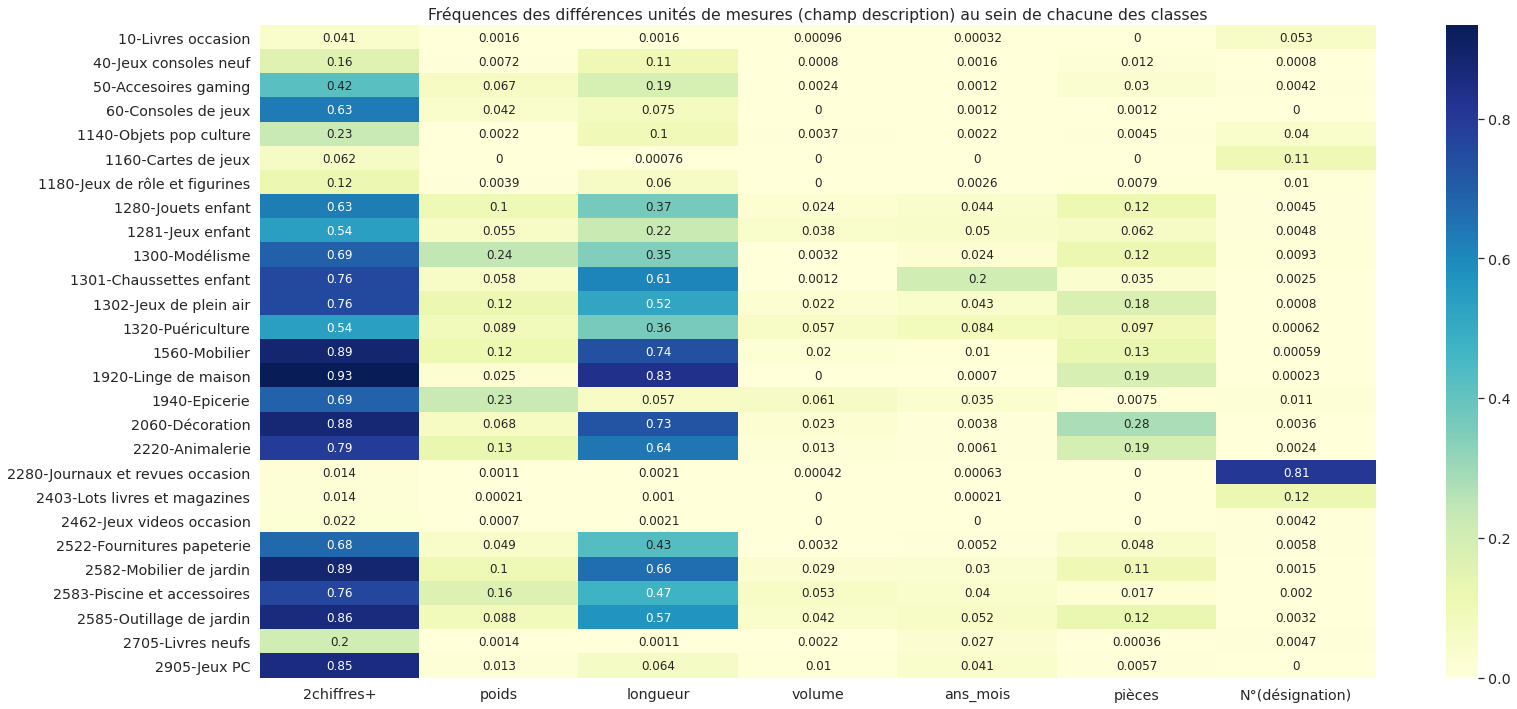

In [31]:
#HEATMAP REGEX
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

url = "https://raw.githubusercontent.com/JulienJ-44/rakuteam/main/Streamlit_rakuten/Demo/df_classes_avec_code_libelle_code026.csv"
download = requests.get(url).content
class_codes = pd.read_csv(io.StringIO(download.decode('utf-8')), index_col=1)
#on étudie le champ description
colonneClass = "description" 
df_results = pd.DataFrame(columns=['2chiffres+','poids','longueur','volume','ans_mois','pièces','N°(désignation)'])#, 'date','octets','dimension'
class_text_cols = []
#on parcourt la liste des classes

for class_code in class_codes.index:
  #on copie dans un df temporaire les lignes correspondant au code de classe actuel
  df_current_class = df[df.prdtypecode==class_code]
  #affichage des infos de la classe
  #print("Classe:", class_code, "\n", len(df_current_class.index), " éléments")
  nb_total = len(df_current_class.index)
  #nb d articles contenant la regexp / nb d articles total dans la classe
  nb_occur1=(len(df_current_class[df_current_class["desc_nb2chiffres+"] > 0]))/nb_total
  nb_occur4=(len(df_current_class[df_current_class["desc_poids"] > 0]))/nb_total
  nb_occur5=(len(df_current_class[df_current_class["desc_long"] > 0]))/nb_total
  nb_occur7=(len(df_current_class[df_current_class["desc_vol"] > 0]))/nb_total
  #nb_occur2=(len(df_current_class[df_current_class["desc_Go"] > 0]))/nb_total
  #nb_occur3=(len(df_current_class[df_current_class["desi_num"] > 0]))/nb_total
  nb_occur12=(len(df_current_class[df_current_class["desi_num"] > 0]))/nb_total
  nb_occur8=(len(df_current_class[df_current_class["desc_ans_mois"] > 0]))/nb_total
  nb_occur9=(len(df_current_class[df_current_class["desc_pieces"] > 0]))/nb_total
  new_row = pd.Series(data={'2chiffres+':nb_occur1,
                            #,'dimension':nb_occur6, 'date':nb_occur10 'octets':nb_occur2,
                            'poids':nb_occur4,'longueur':nb_occur5,'volume':nb_occur7
                            ,'ans_mois':nb_occur8,'N°(désignation)':nb_occur12,'pièces':nb_occur9}
                      , name=str(class_code)+ "-"+class_codes.loc[class_code,"désignation"])
  df_results = df_results.append(new_row, ignore_index=False)


plt.figure(figsize=(25,12))
annot_kws={'fontsize':12}
sns.heatmap(df_results, annot=True, cmap='YlGnBu', annot_kws=annot_kws);
sns.set(font_scale=1.3)
p = plt.title("Fréquences des différences unités de mesures (champ description) au sein de chacune des classes");
images_dir = '/Drive/My Drive/Colab Notebooks'
plt.savefig(f"{images_dir}/Frequence_unites_par_classe.png")

In [ ]:
def add_features_to_manualdf(df):
  df=add_nb_phrases(df)
  df["best_idf"]=0
  #lst_keywords_byclass contient: {1180:[mot1 mot2 mot3 ...], 2520:[mot1 mot2 mot3 ...] ...}
  #lst_keywords_byclass = sorted(lst_keywords_byclass)
  for (key_kw, value_kw) in sorted(lst_keywords_byclass.items()):
    #key_kw=1180
    #value_kw=[mot1 mot2 mot3 ...]
    df['class_'+str(key_kw)]=df['designation'].apply(lambda x: scoring(x, value_kw))
  df=add_bestidf(df)
  df=add_regex1(df)
  df=add_regex2(df)
  return df

#TEST  add_features_to_manualdf
isManualData=True
if (isManualData):
  madescription=""
  madesignation="bébé"
  df=clean_manualdata(madescription, madesignation)
  add_features_to_manualdf(df)
df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,designation,description,productid,prdtypecode,desi_nb_phrases,desc_nb_phrases,best_idf,class_10.0,class_40.0,class_50.0,class_60.0,class_1140.0,class_1160.0,class_1180.0,class_1280.0,class_1281.0,class_1300.0,class_1301.0,class_1302.0,class_1320.0,class_1560.0,class_1920.0,class_1940.0,class_2060.0,class_2220.0,class_2280.0,class_2403.0,class_2462.0,class_2522.0,class_2582.0,class_2583.0,class_2585.0,class_2705.0,class_2905.0,desi_nb2chiffres+,desc_nb2chiffres+,desi_num,desi_poids,desc_poids,desi_long,desc_long,desi_vol,desc_vol,desi_ans_mois,desc_ans_mois,desi_pieces,desc_pieces,desi_word_count,desi_char_count (w/o space),desi_total_length,desi_num_exclamation_marks,desi_num_question_marks,desi_num_unique_words,desi_words_vs_unique,desi_word_unique_percent,descri_word_count,descri_char_count (w/o space),descri_total_length,descri_num_exclamation_marks,descri_num_question_marks,descri_num_unique_words,descri_words_vs_unique,descri_word_unique_percent
0,bébé,,0,None,1,0,class_1320.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.134,0.113,0.0,0.324,0.0,0.468,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4,4,0,0,1,1.0,100.0,0,0,0,0,0,0,NaN,NaN


In [ ]:
df.to_csv(f'{pathSaveCsv}/features_texte.csv')